In [2]:
library(tidyverse)

library(earth)
library(caret)

library(vip)
library(pdp)

In [4]:
ames <- ames <- AmesHousing::make_ames()
index <- sample(1:dim(ames)[1], 0.7*dim(ames)[1])
ames_train <- ames[index,]
ames_test <- ames[-index,]

### 기본 아이디어
- 선형 모델을 확장하여 모든 비선형 관계를 캡처할 수 있다.
- polynomial 회귀 함수의 차수가 3 또는 4보다 클수록 적합이 과도하게 유연해지고, 기이한 모양, 다중공선성의 발생을 증가

<br/>

- 다항식의 대안은 step function을 사용하는 것
- 다항식 함수가 전역의 비선형 관계를 부과하는 반면, 단계 함수는 구간에 넣고 간단한 상수를 맞춤
- 유용하지만, polynomial 회귀 및 step function의 일반적인 구현은 사용자가 특정 상호작용 정도 또는 변수의 어떤 지점에서 어떤 변수가 있어야 하는지 식별하고 통합해야함

### 다변수 적응 회귀 스플라인 
### Multivariate adaptive regression splines (MARS)

- MARS는 단계 함수와 유사한 컷 포인트(knot)를 평가하여 데이터의 비선형 관계를 캡쳐
- 각 예측변수에 대해 knot별로 선형회귀 모델을 생성하고 추정
- 많은 매듭을 포함하면 좋은 관계를 맞출 수 있지만, 새로운 데이터에는 일반화 되지 않음
- 매듭의 전체 집합중, 예측 정확도에 크게 기여하지 않는 매듭을 순차적으로 제거(가지치기)
- 교차검증을 사용하여 최적의 매듭 수 탐색

- MARS는 자연스럽게 혼합 유형의 예측 변수(정량적 및 정성적)를 처리
- MARS는 예측 정확도를 향상시키는 분할을 식별하기 위해 각 예측 변수를 스캔하므로 정보가 없는 기능은 선택되지 않음
- 상관관계가 높은 예측 변수는 OLS 모델만큼 예측 정확도를 저해하지 않음

### ```earth::earth()```
- 잠재적 매듭을 평가한 다음, R^2의 예상되는 변경사항을 기반으로 최적의 매듭 수로 정리
- GCV에 의해 수행, 대략적인 LOOCV 교차검증 오류 메트릭을 생성하는 선형 모델의 계산

In [5]:
mars1 <- earth(
    Sale_Price ~ .,
    data = ames_train
)

In [6]:
mars1 %>% print

Selected 37 of 41 terms, and 26 of 308 predictors
Termination condition: RSq changed by less than 0.001 at 41 terms
Importance: Gr_Liv_Area, Year_Built, Overall_QualExcellent, ...
Number of terms at each degree of interaction: 1 36 (additive model)
GCV 477865800    RSS 9.11576e+11    GRSq 0.9227368    RSq 0.9280688


#### 최적의 매듭 수
- 모형이 범주형 변수를 자동으로 더미 인코딩 => 308 predictors
- 308개의 변수중 26개에서 생성된 41개의 구간(계수)중 37개(절편포함)의 구간(계수)이 모형생성에 사용 

In [24]:
summary(mars1) %>% .$coefficients %>% head(10)

,Sale_Price
(Intercept),206262.39424
h(Gr_Liv_Area-2978),-101.09886
h(2978-Gr_Liv_Area),-44.41976
h(Year_Built-2002),1909.32874
h(2002-Year_Built),-402.51352
h(Total_Bsmt_SF-1273),62.34903
h(1273-Total_Bsmt_SF),-25.62092
h(Bsmt_Unf_SF-542),-24.60304
h(542-Bsmt_Unf_SF),9.16462
h(Garage_Cars-2),13480.02587


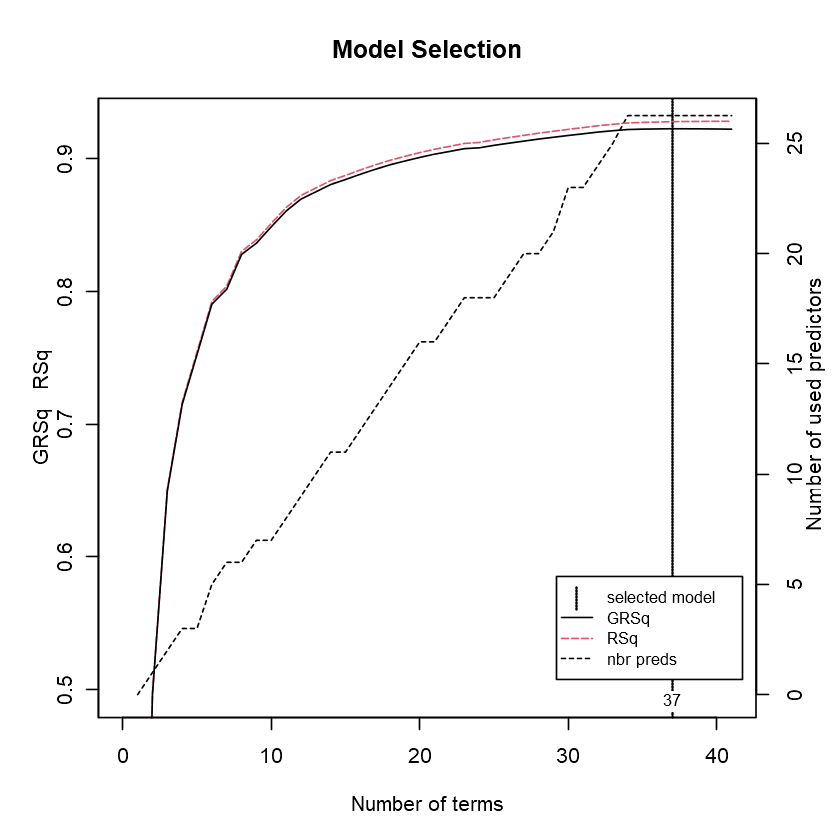

In [12]:
plot(mars1, which = 1)

- 26개의 변수를 기반으로 하는 36개의 비절편 항이 유지
- 이 36개이상으로 모델에 유지되는 추가항은 GCV에서 0.001미만의 개선을 가져옴

### 상호작용항
#### ```degree = ```

In [25]:
mars2 <- earth(
  Sale_Price ~ .,  
  data = ames_train,
  degree = 2
)

In [27]:
mars2 %>% print

Selected 46 of 53 terms, and 30 of 308 predictors
Termination condition: RSq changed by less than 0.001 at 53 terms
Importance: Gr_Liv_Area, Year_Built, Overall_QualExcellent, ...
Number of terms at each degree of interaction: 1 24 21
GCV 365775006    RSS 6.69471e+11    GRSq 0.9408601    RSq 0.947173


In [26]:
summary(mars2) %>% .$coefficients %>% head(10)

,Sale_Price
(Intercept),2.572853e+05
h(Gr_Liv_Area-2978),8.051133e+01
h(2978-Gr_Liv_Area),-4.941907e+01
h(Year_Built-2002),3.580400e+03
h(2002-Year_Built),-3.041617e+02
h(Total_Bsmt_SF-1273),3.841760e+01
h(1273-Total_Bsmt_SF),-3.250939e+01
h(Year_Built-2002)*h(2331-Gr_Liv_Area),-3.429841e+00
h(Bsmt_Unf_SF-1232)*h(2978-Gr_Liv_Area),-2.465793e-02
h(1232-Bsmt_Unf_SF)*h(2978-Gr_Liv_Area),6.738648e-03


### 튜닝
- MARS 모델과 관련된 조정 매개변수
1. 상호작용 차수
2. 최종 모델에 유지되는 항의 수

- 3차 이상의 상호 작용을 평가할 때 10개의 균일한 간격 값으로 nprune

In [30]:
hyper_grid <- expand.grid(
  degree = 1:3, 
  nprune = seq(2, 100, length.out = 10) %>% floor()
)

In [31]:
head(hyper_grid)

,degree,nprune
,<int>,<dbl>
1,1,2
2,2,2
3,3,2
4,1,12
5,2,12
6,3,12


In [ ]:
set.seed(123)  
cv_mars <- train(
  x = subset(ames_train, select = -Sale_Price),
  y = ames_train$Sale_Price,
  method = "earth",
  metric = "RMSE",
  trControl = trainControl(method = "cv", number = 10),
  tuneGrid = hyper_grid
)

In [47]:
dim(ames_train)

[1] 2051   81

In [46]:
cv_mars

Multivariate Adaptive Regression Spline 

2051 samples
  80 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1846, 1846, 1846, 1847, 1846, 1845, ... 
Resampling results across tuning parameters:

  degree  nprune  RMSE      Rsquared   MAE     
  1         2     56368.81  0.4891968  39548.70
  1        12     30607.41  0.8476713  20671.18
  1        23     27223.59  0.8786089  17335.97
  1        34     25462.29  0.8931864  16340.94
  1        45     25143.67  0.8957990  16079.39
  1        56     25143.67  0.8957990  16079.39
  1        67     25143.67  0.8957990  16079.39
  1        78     25143.67  0.8957990  16079.39
  1        89     25143.67  0.8957990  16079.39
  1       100     25143.67  0.8957990  16079.39
  2         2     56394.41  0.4869650  39327.76
  2        12     28821.93  0.8649771  20627.70
  2        23     24847.88  0.8998501  17214.60
  2        34     23505.65  0.9105622  16010.83
  2        45     22488.14  0.9178927  1

In [34]:
cv_mars$bestTune

,nprune,degree
,<dbl>,<int>
16,56,2


#### 최적의 모형 (차수 = 2, 구간 = 56)

In [35]:
cv_mars$results %>%
  filter(nprune == cv_mars$bestTune$nprune, degree == cv_mars$bestTune$degree)

degree,nprune,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,56,22465.52,0.9180273,15392.75,2337.729,0.01877691,1071.866


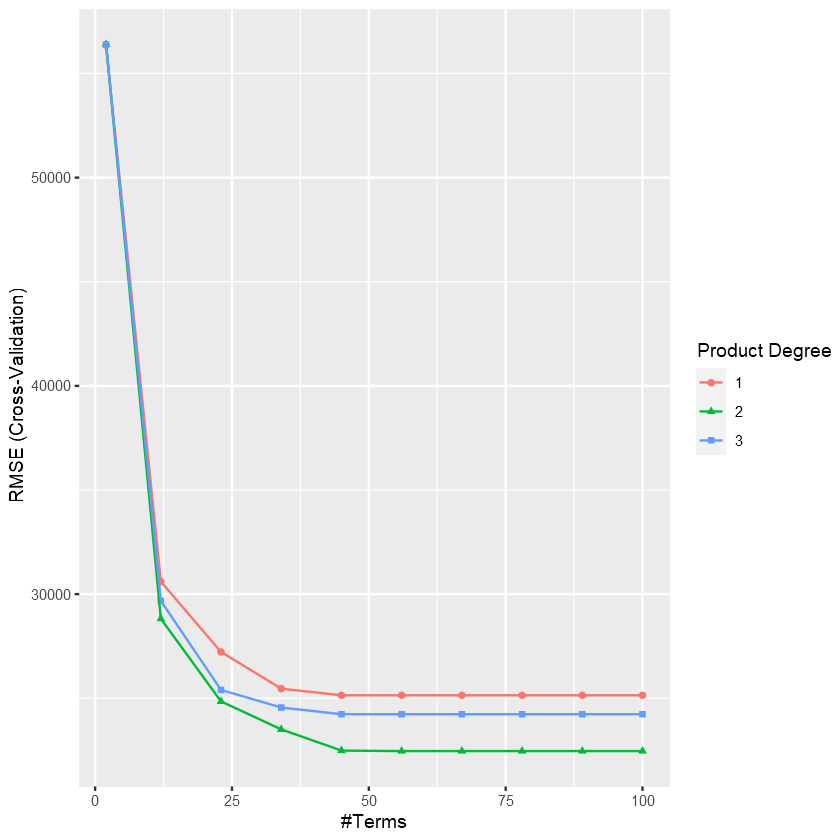

In [36]:
ggplot(cv_mars)

#### fold별 metric

In [37]:
cv_mars$resample

RMSE,Rsquared,MAE,Resample
<dbl>,<dbl>,<dbl>,<chr>
18550.75,0.9430993,13465.63,Fold03
23936.04,0.8991507,16727.05,Fold04
21862.46,0.9218667,14851.47,Fold08
19197.05,0.9404627,13766.83,Fold07
26776.85,0.8807989,16408.56,Fold01
23028.86,0.9132166,15755.53,Fold05
23711.82,0.9107886,15994.23,Fold09
22872.77,0.9304104,15849.78,Fold02
22402.23,0.9154693,15306.19,Fold06


### 변수 중요도
- GCV와 RSS에 영향을 주는 변수

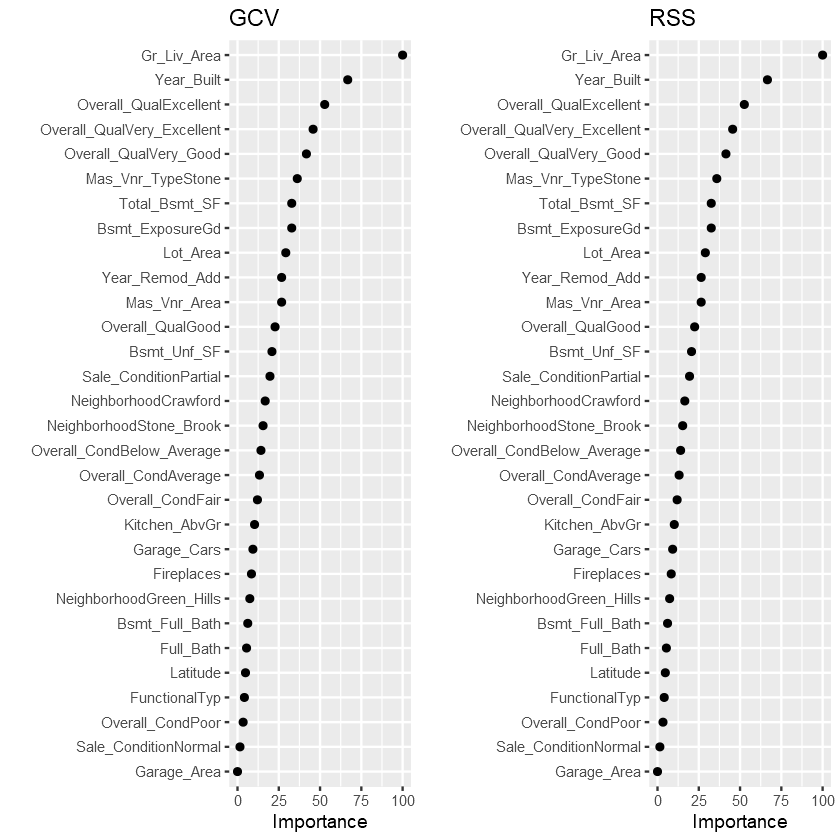

In [38]:
p1 <- vip(cv_mars, num_features = 40, geom = "point", value = "gcv") + ggtitle("GCV")
p2 <- vip(cv_mars, num_features = 40, geom = "point", value = "rss") + ggtitle("RSS")

gridExtra::grid.arrange(p1, p2, ncol = 2)

In [42]:
cv_mars$finalModel %>%
  coef() %>%  
  broom::tidy() %>%  
  filter(stringr::str_detect(names, "\\*")) 

Warning message:
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
h(Year_Built-2002) * h(2331-Gr_Liv_Area),-3.429841e+00
h(Bsmt_Unf_SF-1232) * h(2978-Gr_Liv_Area),-2.465793e-02
h(1232-Bsmt_Unf_SF) * h(2978-Gr_Liv_Area),6.738648e-03
h(2002-Year_Built) * h(Total_Bsmt_SF-851),-4.857619e-01
Mas_Vnr_TypeStone * h(Gr_Liv_Area-2978),-4.320519e+02
h(Year_Remod_Add-1973) * h(Garage_Area-380),8.616197e-01
h(Total_Bsmt_SF-1273) * h(Full_Bath-2),6.382728e+01
h(Total_Bsmt_SF-1273) * h(2-Full_Bath),3.745505e+01
Bsmt_ExposureGd * h(Total_Bsmt_SF-1273),4.579922e+01


### PDP

Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."
Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."


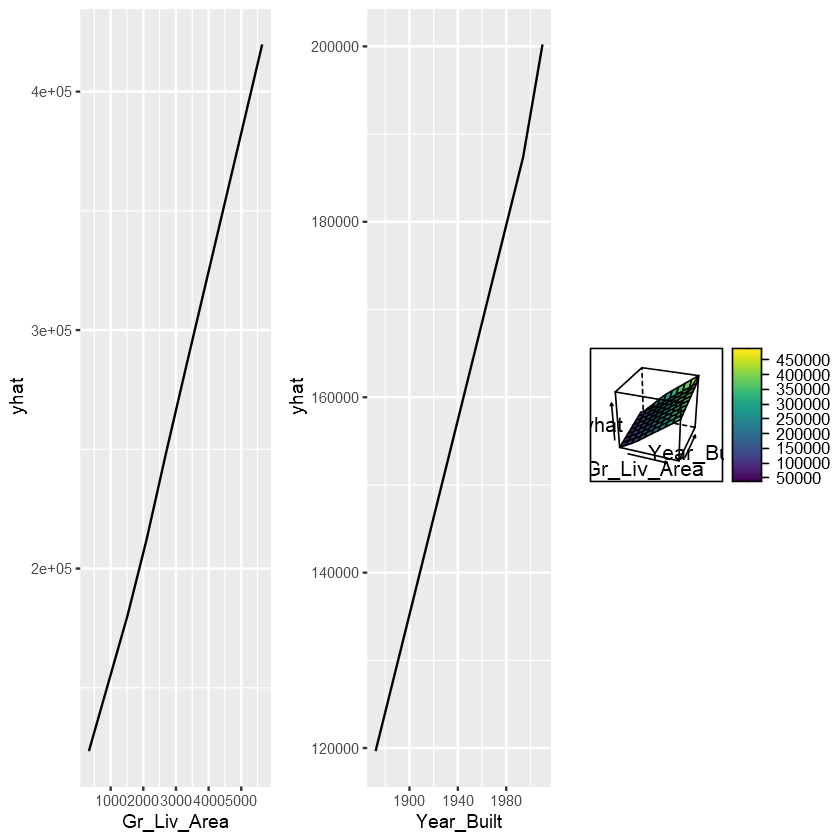

In [40]:
p1 <- partial(cv_mars, pred.var = "Gr_Liv_Area", grid.resolution = 10) %>% 
  autoplot()
p2 <- partial(cv_mars, pred.var = "Year_Built", grid.resolution = 10) %>% 
  autoplot()
p3 <- partial(cv_mars, pred.var = c("Gr_Liv_Area", "Year_Built"), 
              grid.resolution = 10) %>% 
  plotPartial(levelplot = FALSE, zlab = "yhat", drape = TRUE, colorkey = TRUE, 
              screen = list(z = -20, x = -60))

gridExtra::grid.arrange(p1, p2, p3, ncol = 3)

### MARS 로지스틱 회귀

In [43]:
attrition <- read.csv("C:/Users/apf_temp_admin/Documents/Hands on Machine Learning/WA_Fn-UseC_-HR-Employee-Attrition.csv",
                     stringsAsFactors = T)
colnames(attrition)[1] <- "Age"
set.seed(123)
churn_split <- rsample::initial_split(attrition, prop = 0.7, strata = "Attrition")
churn_train <- rsample::training(churn_split)
churn_test <- rsample::testing(churn_split)

In [ ]:
set.seed(123)
tuned_mars <- train(
  x = subset(churn_train[, -c(9, 22, 27)], select = -Attrition),
  y = churn_train[, -c(9, 22, 27)]$Attrition,
  method = "earth",
  trControl = trainControl(method = "cv", number = 10),
  tuneGrid = hyper_grid
)

,nprune,degree
,<dbl>,<int>
3,23,1


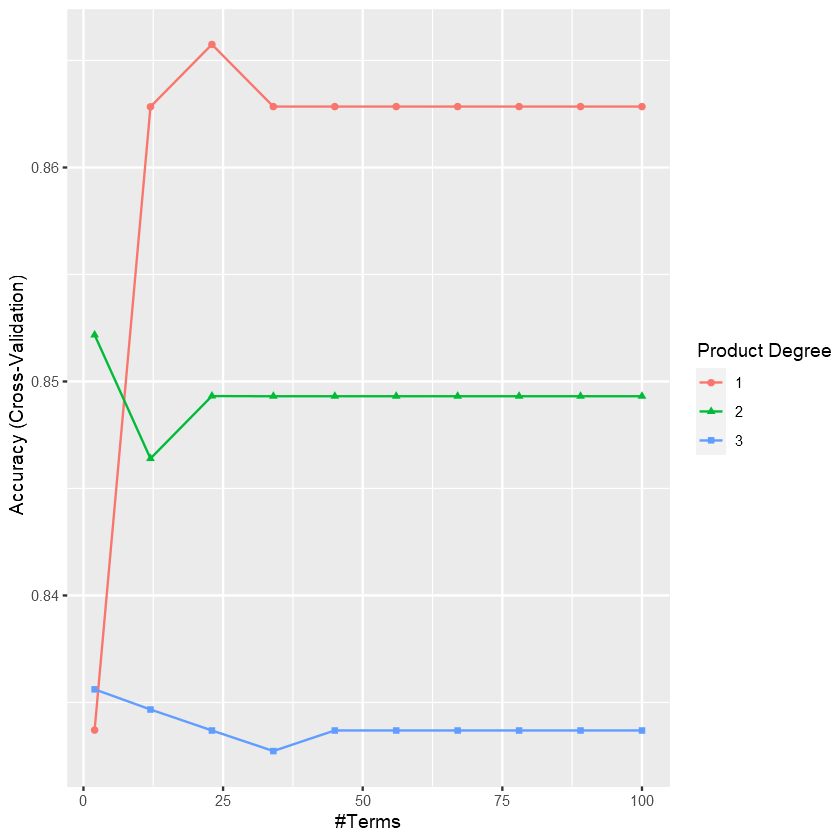

In [45]:
tuned_mars$bestTune
ggplot(tuned_mars)